In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import tqdm as notebook_tqdm
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy
from sklearn.neighbors import NearestNeighbors

In [6]:
from cache import cache_np
from embeddings import encode
from metrics import (
    cosine_distance,
    euclidean_distance,
    cosine_distance_matrix,
    cosine_similarity_matrix,
)
from loaders import load_user_item_matrix, Loader
from filters import items_of_user, find_closest_vectors
from evaluation import calculate_tp_fp_fn_tn, calculate_precision_and_recall, f1_score, rmse
from recommenders import Recommender


/usr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load CiteULike-a dataset


In [7]:
loader = Loader("../datasets/citeulike-a/")
loader.load_docs().head()


,doc.id,citeulike.id,raw.title,raw.abstract
0,1,42.0,The metabolic world of Escherichia coli is not...,To elucidate the organizational and evolutiona...
1,2,43.0,Reverse Engineering of Biological Complexity,Advanced technologies and biology have extreme...
2,3,44.0,Exploring complex networks,"The study of networks pervades all of science,..."
3,4,46.0,Comparative assessment of large-scale data set...,Comprehensive protein protein interaction maps...
4,5,47.0,Navigation in a small world,The small-world phenomenon — the principle tha...


### Load tags

In [8]:
len(loader.load_tags()), loader.load_tags()[:5], loader.get_tag_id("machine-learning")


(46391,
 array(['ucsc-browser', 'rr_interval', 'userscripts', 'newsciencenetwork',
        'sequence_similarity_search'], dtype='<U73'),
 12946)

In [9]:
item_tag_matrix = loader.load_item_tag_matrix()
item_tag_matrix.shape


(16980, 46391)

In [10]:
item_tags = np.where(item_tag_matrix[0, :] > 0)[0]
len(item_tags), item_tags


(17,
 array([ 3378,  3805,  4276,  7650, 12234, 23779, 25497, 28819, 30698,
        32443, 37386, 37837, 42140, 42810, 43503, 43806, 44590]))

### Recommender

In [11]:
reco = Recommender(loader)


### Search by title


In [12]:
_, indices = reco.embedding_title_search("machine learning", 5)

loader.load_docs().iloc[indices]


,doc.id,citeulike.id,raw.title,raw.abstract
1029,1030,110407.0,Artificial Intelligence,{<i>Artificial Intelligence</i> is a somewhat ...
1181,1182,115590.0,Machine Learning,Machine Learning is the study of methods for p...
724,725,97160.0,Data Mining,Group 14 used data-mining strategies to evalua...
2388,2389,165116.0,Random Forests,Abstract. Random forests are a combination of ...
10905,10906,1197459.0,Pattern Recognition and Machine Learning,The dramatic growth in practical applications ...


### Search by abstract


In [13]:
_, indices = reco.embedding_abstract_search("machine learning", 5)

loader.load_docs().iloc[indices]


,doc.id,citeulike.id,raw.title,raw.abstract
1181,1182,115590.0,Machine Learning,Machine Learning is the study of methods for p...
10969,10970,1218597.0,Some studies in machine learning using the gam...,Two machine-learning procedures have been inve...
4027,4028,297799.0,Introduction to Machine Learning (Adaptive Com...,{The goal of machine learning is to program co...
4689,4690,340715.0,Data Mining: Practical Machine Learning Tools ...,As with any burgeoning technology that enjoys ...
11750,11751,1442986.0,Machine Learning and Its Applications to Biology,The term machine learning refers to a set of t...


### Tags

In [14]:
item_id = 21
loader.load_docs().iloc[item_id]["raw.title"], loader.get_item_tag_names(item_id)


('Growing and navigating the small world Web by local content.',
 array(['local', 'search', 'networks', 'crawling'], dtype='<U73'))

In [15]:
_, indices = reco.collaborative_similar_items_using_tags(21, 5)

loader.load_docs().iloc[indices]


/home/tmscer/proj/fel/bthe/src/metrics.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + h)


,doc.id,citeulike.id,raw.title,raw.abstract
1352,1353,121053.0,A Random Graph Model for Massive Graphs,We propose a random graph model which is a spe...
92,93,576.0,Modeling the evolution of weighted networks,We present a general model for the growth of w...
3040,3041,219664.0,How Do Networks Become Navigable?,Networks created and maintained by social proc...
21,22,127.0,Growing and navigating the small world Web by ...,Can we model the scale-free distribution of We...
5901,5902,431738.0,A Review of Evolutionary Artificial Neural Net...,Research on potential interactions between con...


In [16]:
_, indices = reco.embedding_tag_search("machine learning", 10)
loader.load_tags()[indices]


array(['machine-learning', 'automatic-learning', 'machinelearning',
       'classifiers', 'machine-learning-methods', 'machine_learning',
       'data-mining-machine-learning', 'statistical-learning',
       'deep-learning', 'data-mining'], dtype='<U73')

### Papers read by some user


In [17]:
number_of_items_per_user = np.sum(loader.load_user_item_matrix(), axis=1)

chosen_user = 42
print(
    f"User #{chosen_user} has interacted with {number_of_items_per_user[chosen_user]} items"
)

print("Their items (10):")
relevant = reco.relevant_items(chosen_user)
loader.load_docs().iloc[relevant]


User #42 has interacted with 42 items
Their items (10):


,doc.id,citeulike.id,raw.title,raw.abstract
41,42,242.0,"XML, bioinformatics and data integration.",Motivation: The eXtensible Markup Language (XM...
701,702,95914.0,On the criteria to be used in decomposing syst...,This paper discusses modularization as a mecha...
888,889,104334.0,Design Patterns: Elements of Reusable Object-O...,_Design Patterns_ is based on the idea that th...
1041,1042,111765.0,No {S}ilver {B}ullet: {E}ssence and {A}ccident...,Of all the monsters that fill the nightmares o...
1136,1137,115159.0,Software Architecture: Perspectives on an Emer...,{ Good software developers often adopt one or...
1375,1376,121547.0,Writing {G}ood {S}oftware {E}ngineering {R}ese...,Software engineering researchers solve problem...
1460,1461,126034.0,Software Engineering Economics,This paper summarizes the current state of the...
1787,1788,133565.0,"Generative Programming: Methods, Tools, and Ap...",{The authors present a grand tour of Generativ...
1933,1934,140601.0,Code Complete: A Practical Handbook of Softwar...,"For more than a decade, Steve McConnell, one o..."
1947,1948,140708.0,Software Systems as Complex Networks: Structur...,Software systems emerge from mere keystrokes t...


### Item-KNN Content-Based Recommender


In [18]:
_, recommendations = reco.embedding_similar_items(relevant[0], k=5 + 1)
recommendations = np.setdiff1d(recommendations, relevant)

loader.load_docs().iloc[recommendations]


,doc.id,citeulike.id,raw.title,raw.abstract
2689,2690,192797.0,Data on the Web: from relations to semistructu...,<I>Data on the Web: From Relations to Semistru...
13360,13361,2587350.0,State of the nation in data integration for bi...,Data integration is a perennial issue in bioin...
15887,15888,5444878.0,An XML transfer schema for exchange of genomic...,"ABSTRACT: BACKGROUND: Genomic analysis, partic..."
16137,16138,6016560.0,phyloXML: XML for evolutionary biology and com...,{BACKGROUND:Evolutionary} trees are central to...
16894,16895,7801404.0,BioXSD: the common data-exchange format for ev...,MOTIVATION: The world-wide community of life s...


### User-KNN CF


In [19]:
ratings = reco.collaborative_user_knn(chosen_user, 10)
# ratings = np.setdiff1d(recommendations, relevant)

print("max score", np.max(ratings))

recommendations = np.argsort(ratings)[::-1]

loader.load_docs().iloc[recommendations[:5]]


max score 0.6697104584975075


,doc.id,citeulike.id,raw.title,raw.abstract
4257,4258,312079.0,{Feature--Oriented Domain Analysis (FODA) Feas...,Successful software reuse requires the systema...
4252,4253,312060.0,Staged Configuration Using Feature Models,Feature modeling is an important approach to c...
4262,4263,312116.0,On the Notion of Variability in Software Produ...,Software product lines are used in companies t...
4255,4256,312063.0,Domain--Specific Language Design Requires Feat...,A domain-specific language (DSL) provides a no...
4133,4134,305952.0,"Feature Models, Grammars, and Propositional Fo...",Feature models are used to specify members of ...


### Item-KNN CF


In [20]:
item_scores = np.zeros(loader.num_items())
print(loader.num_items())

for item_id in range(loader.num_items()):
    item_scores[item_id] = reco.collaborative_item_knn(chosen_user, item_id, 10)

print("max score", np.max(item_scores))
recommendations = np.argsort(item_scores)[::-1]

loader.load_docs().iloc[recommendations[:5]]


16980
max score 0.9072556372747054


,doc.id,citeulike.id,raw.title,raw.abstract
8017,8018,625300.0,Implementing product line variabilities,Software product lines have numerous members. ...
10218,10219,1019016.0,Variability management with feature-oriented p...,This paper presents an analysis of feature-ori...
5322,5323,386084.0,Software Product Line Engineering: Foundations...,"{This textbook addresses students, professiona..."
4249,4250,312031.0,Managing Variability in Software Architectures,This paper presents experience with explicitly...
4256,4257,312073.0,Integrating Feature Modeling with the {RSEB},We have integrated the feature modeling of Fea...


### User-KNN CF and weigh users by max item similarity


In [21]:
k_items = 10
item_scores = reco.embedding_weighted_similar_items(
    chosen_user, k_users=20, pooling="max"
)
recommendations = np.argsort(item_scores)[::-1][:k_items]
recommendations = np.setdiff1d(recommendations, relevant)

loader.load_docs().iloc[recommendations]


,doc.id,citeulike.id,raw.title,raw.abstract
4252,4253,312060.0,Staged Configuration Using Feature Models,Feature modeling is an important approach to c...
4255,4256,312063.0,Domain--Specific Language Design Requires Feat...,A domain-specific language (DSL) provides a no...
4258,4259,312080.0,{FORM}: {A} feature--oriented reuse method wit...,Abstract&nbsp;&nbsp;Systematic discovery and e...


### Evaluation

In [22]:
original_user_item_matrix = None


def forget(rate):
	global original_user_item_matrix
	
	# Forget previous augmented user-item matrix and reload
	reco.loader.user_item_matrix = None
	original_user_item_matrix = reco.loader.load_user_item_matrix().copy()


	for user_id in range(loader.num_users()):
		relevant = reco.relevant_items(user_id)
		np.random.shuffle(relevant)

		to_remove = relevant[:int(len(relevant) * rate)]
		reco.loader.user_item_matrix[user_id, to_remove] = 0


	num_ratings_per_user = np.sum(reco.loader.user_item_matrix, axis=1)

	users_without_ratings = np.where(num_ratings_per_user == 0)[0]

	assert len(users_without_ratings) == 0


In [35]:
def item_in_array_startswith(arr, item):
	if type(arr) == list:
		for arr_item in arr:
			if arr_item.startswith(item):
				return arr_item

	if type(arr) == str:
		if arr.startswith(item):
			return arr

	return False


In [36]:
item_in_array_startswith("text-similarity-max", "text-similarity"), "text-similarity-max".split("-")[-1]


('text-similarity-max', 'max')

In [37]:
item_in_array_startswith(["abc", "text-similarity-max"], "text-similarity"), "text-similarity-max".split("-")[-1]


('text-similarity-max', 'max')

In [147]:
def create_ratings_func(weight_method, weights=None):
	if weights is None:
		weights = np.array([1] * len(weight_method))
	else:
		weights = np.array(weights)

	if type(weight_method) == list and len(weights) != len(weight_method):
		raise ValueError("Length of weights and weight_method must be equal")

	funcs = []

	if "random" in weight_method:
		print("Adding random weights")
		funcs.append(lambda _user_id, _k: np.random.random_sample(reco.loader.num_items()))

	if "identity" in weight_method:
		print("Adding identity weights")
		funcs.append(lambda user_id, _k: reco.loader.load_user_item_matrix()[user_id, :].astype(np.float32))

	if "user-similarity" in weight_method:
		print("Adding user-similarity weights")
		funcs.append(lambda user_id, k: reco.collaborative_user_knn(user_id, k))

	if (wm := item_in_array_startswith(weight_method, "text-similarity")):
		pooling = wm.split("-")[-1]
		print(f"Adding text-similarity weights with pooling={pooling}")
		funcs.append(lambda user_id, k: reco.embedding_weighted_similar_items(user_id, k, pooling=pooling, embeddings="text"))

	if (wm := item_in_array_startswith(weight_method, "title-similarity")):
		pooling = wm.split("-")[-1]
		print(f"Adding title-similarity weights with pooling={pooling}")
		funcs.append(lambda user_id, k: reco.embedding_weighted_similar_items(user_id, k, pooling=pooling, embeddings="title"))

	if (wm := item_in_array_startswith(weight_method, "abstract-similarity")):
		pooling = wm.split("-")[-1]
		print(f"Adding abstract-similarity weights with pooling={pooling}")
		funcs.append(lambda user_id, k: reco.embedding_weighted_similar_items(user_id, k, pooling=pooling, embeddings="abstract"))

	def get_ratings(user_id, k):
		ratings = np.zeros(reco.loader.num_items())

		for i, func in enumerate(funcs):
			ratings += weights[i] * func(user_id, k)

		return ratings / np.sum(weights)

	return get_ratings


In [55]:
from evaluation import is_there_a_hit, hitrate


def evaluate(k=10, weight_method="user-similarity", weights=None):
	m = loader.num_users()
	sum_prec, sum_recall = 0, 0
	hits = np.zeros(m)
	different_items = set()
	calculated_ratings = []
	num_weight_methods = 1 if type(weight_method) == str else len(weight_method)

	get_ratings = create_ratings_func(weight_method, weights)

	for user_id in range(m):
		ratings = get_ratings(user_id, k)

		relevant_train = np.where(reco.loader.load_user_item_matrix()[user_id, :] > 0)[0]
		inferred_ratings_for_train = ratings[relevant_train]

		# Disregard items that was used for the prediction, this might cripple coverage
		ratings[relevant_train] = -np.inf

		recommendations = np.argsort(ratings)[::-1][:k]
		different_items = different_items.union(set(recommendations))

		relevant = np.where(original_user_item_matrix[user_id, :] > 0)[0]
		# Remove ground truth items that were used for the prediction
		relevant_evaluated = np.setdiff1d(relevant, relevant_train)
		hits[user_id] = is_there_a_hit(recommendations, relevant_evaluated)

		tp_fp_fn_tn = calculate_tp_fp_fn_tn(recommendations, relevant_evaluated, loader.num_items())
		precision, precall = calculate_precision_and_recall(tp_fp_fn_tn)

		sum_prec += precision
		sum_recall += precall

		# Restore ratings for training items so that we can calculate RMSE
		ratings[relevant_train] = inferred_ratings_for_train
		calculated_ratings.append(ratings)


	calculated_ratings = np.array(calculated_ratings)

	coverage = len(different_items) / loader.num_items()
	overall_precision = sum_prec / m
	overall_recall = sum_recall / m
	overall_hitrate = hitrate(hits)

	return {
		"precision": overall_precision,
		"recall": overall_recall,
		"hitrate": overall_hitrate,
		"coverage": coverage,
		"rmse": rmse(calculated_ratings, original_user_item_matrix),
		"k": k,
		"weight_method": weight_method,
	}


In [133]:
forget(0.97)
evaluate(20, "user-similarity")


Adding user-similarity weights


{'precision': 0.16162853539902636,
 'recall': 0.12209940474759626,
 'hitrate': 0.9342460817870654,
 'coverage': 0.36725559481743225,
 'rmse': 0.047233439736210484,
 'k': 20,
 'weight_method': 'user-similarity'}

In [139]:
evaluate(20, "text-similarity-mean")


Adding text-similarity weights with pooling=mean


{'precision': 0.16349306431273547,
 'recall': 0.12324686580398055,
 'hitrate': 0.9324446045757521,
 'coverage': 0.36625441696113076,
 'rmse': 0.04714850105935813,
 'k': 20,
 'weight_method': 'text-similarity1-mean'}

In [52]:
evaluate(20, "identity")


Adding identity weights


{'precision': 0.0012610340479192917,
 'recall': 0.0007803481097215292,
 'hitrate': 0.019095658439920737,
 'coverage': 0.002061248527679623,
 'rmse': 0.04702008686812493,
 'k': 20,
 'weight_method': 'identity'}

In [56]:
evaluate(20, ["user-similarity", "text-similarity-max"])


Adding user-similarity weights
Adding text-similarity weights with pooling=max


{'precision': 0.15546748333633548,
 'recall': 0.11878813118426111,
 'hitrate': 0.9218158890290038,
 'coverage': 0.3674911660777385,
 'rmse': 0.04680907935056329,
 'k': 20,
 'weight_method': ['user-similarity', 'text-similarity-max']}

In [57]:
evaluate(20, ["user-similarity", "text-similarity-mean"], [0.75, 0.25])


Adding user-similarity weights
Adding text-similarity weights with pooling=max


{'precision': 0.15950279228967687,
 'recall': 0.12084911144413521,
 'hitrate': 0.9266798774995496,
 'coverage': 0.367962308598351,
 'rmse': 0.046582034937871504,
 'k': 20,
 'weight_method': ['user-similarity', 'text-similarity-max']}

#### Hybrid weight search

In [ ]:
for w in np.arange(0.6, 0.85, 0.0125):
	weights = [w, 1 - w]
	
	result = evaluate(10, ["user-similarity", "text-similarity-mean"], weights)
	f1 = f1_score(result["precision"], result["recall"])
	print(w, f1, result)


In [166]:
forget_rates = [0.5, 0.9, 0.97, 0.99]
weight_methods = [
	"user-similarity",
	"random",
	"identity",
	"text-similarity-max",
	"text-similarity-mean",
	"title-similarity-max",
	"title-similarity-mean",
	["user-similarity", "text-similarity-mean"],
]
weights = [
	None,
	None,
	None,
	None,
	None,
	None,
	None,
	# Searched for using the block above
	[0.675, 0.315],
]
# A lot of users don't have that many items, so we can't use a high k
ks = [5, 10, 25, 50]


In [70]:
def ppf(dictionary, rounding=2):
	new_dict = {}

	for key, value in dictionary.items():
		if type(value) in [float, np.float16, np.float32, np.float64, np.float128]:
			new_dict[key] = round(float(value), 2)
		else:
			new_dict[key] = value
	
	return new_dict


ppf({"hi":1.2345, "value": np.sum([1.2, 2.666])})


{'hi': 1.23, 'value': 3.87}

In [84]:
results = []

In [96]:
for forget_rate in forget_rates:
	forget(forget_rate)	

	for weight_method in weight_methods:
		for k in ks:
			result = evaluate(k, weight_method)
			result["forget_rate"] = forget_rate

			print(ppf(result))
			results.append(result)

		print("----------")

	print("==========")


Adding user-similarity weights
{'precision': 0.24, 'recall': 0.05, 'hitrate': 0.7, 'coverage': 0.25, 'rmse': 0.05, 'k': 5, 'weight_method': 'user-similarity', 'forget_rate': 0.99}
Adding user-similarity weights
{'precision': 0.2, 'recall': 0.08, 'hitrate': 0.83, 'coverage': 0.27, 'rmse': 0.05, 'k': 10, 'weight_method': 'user-similarity', 'forget_rate': 0.99}
Adding user-similarity weights
{'precision': 0.14, 'recall': 0.13, 'hitrate': 0.96, 'coverage': 0.27, 'rmse': 0.05, 'k': 25, 'weight_method': 'user-similarity', 'forget_rate': 0.99}
Adding user-similarity weights
{'precision': 0.11, 'recall': 0.19, 'hitrate': 0.99, 'coverage': 0.27, 'rmse': 0.05, 'k': 50, 'weight_method': 'user-similarity', 'forget_rate': 0.99}
----------
Adding random weights
{'precision': 0.0, 'recall': 0.0, 'hitrate': 0.01, 'coverage': 0.8, 'rmse': 0.11, 'k': 5, 'weight_method': 'random', 'forget_rate': 0.99}
Adding random weights
{'precision': 0.0, 'recall': 0.0, 'hitrate': 0.02, 'coverage': 0.96, 'rmse': 0.11,

#### Results

In [161]:
def join_weight_method(weight_method):
	if type(weight_method) == str:
		return weight_method
	else:
		return ", ".join(weight_method)


join_weight_method("user-similarity"), join_weight_method(["user-similarity", "text-similarity-mean"])

('user-similarity', 'user-similarity, text-similarity-mean')

In [162]:
df = pd.DataFrame(results)
df["weight_method"] = df["weight_method"].apply(join_weight_method)
df.head()


,precision,recall,hitrate,coverage,rmse,k,weight_method,forget_rate
0,0.365844,0.145642,0.816069,0.549176,0.046948,5,user-similarity,0.5
1,0.321744,0.245542,0.940011,0.671201,0.046946,10,user-similarity,0.5
2,0.226669,0.400459,0.990993,0.804064,0.046969,25,user-similarity,0.5
3,0.157777,0.519204,0.996757,0.880742,0.047001,50,user-similarity,0.5
4,0.001117,0.000392,0.005585,0.804711,0.105449,5,random,0.5


In [163]:
df["f1"] = f1_score(df["precision"], df["recall"])
df.head()


,precision,recall,hitrate,coverage,rmse,k,weight_method,forget_rate,f1
0,0.365844,0.145642,0.816069,0.549176,0.046948,5,user-similarity,0.5,0.208342
1,0.321744,0.245542,0.940011,0.671201,0.046946,10,user-similarity,0.5,0.278525
2,0.226669,0.400459,0.990993,0.804064,0.046969,25,user-similarity,0.5,0.289484
3,0.157777,0.519204,0.996757,0.880742,0.047001,50,user-similarity,0.5,0.242011
4,0.001117,0.000392,0.005585,0.804711,0.105449,5,random,0.5,0.000580


In [164]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
	pivot = df.pivot_table(index=["forget_rate", "k", "weight_method"], values=["precision", "recall", "hitrate", "f1"]).round(4)

	display(pivot)
	
	pd.io.clipboards.to_clipboard(pivot.to_markdown(), excel=False)


f1  hitrate  \
forget_rate k  weight_method                                            
0.50        5  identity                               0.0004   0.0052   
               random                                 0.0006   0.0056   
               text-similarity-max                    0.1757   0.7716   
               text-similarity-mean                   0.1849   0.7896   
               title-similarity-max                   0.1770   0.7745   
               title-similarity-mean                  0.1848   0.7907   
               user-similarity                        0.2083   0.8161   
               user-similarity, text-similarity-mean  0.1964   0.8054   
            10 identity                               0.0006   0.0085   
               random                                 0.0008   0.0094   
               text-similarity-max                    0.2304   0.9096   
               text-similarity-mean                   0.2402   0.9233   
               title-similarity-max                   0.2307   0.9108   
               title-similarity-mean                  0.2405   0.9224   
               user-similarity                        0.2785   0.9400   
               user-similarity, text-similarity-mean  0.2548   0.9306   
            25 identity                               0.0010   0.0184   
               random                                 0.0011   0.0243   
               text-similarity-max                    0.2415   0.9822   
               text-similarity-mean                   0.2497   0.9865   
               title-similarity-max                   0.2412   0.9811   
               title-similarity-mean                  0.2504   0.9867   
               user-similarity                        0.2895   0.9910   
               user-similarity, text-similarity-mean  0.2584   0.9870   
            50 identity                               0.0013   0.0384   
               random                                 0.0015   0.0479   
               text-similarity-max                    0.2034   0.9928   
               text-similarity-mean                   0.2095   0.9942   
               title-similarity-max                   0.2034   0.9915   
               title-similarity-mean                  0.2097   0.9946   
               user-similarity                        0.2420   0.9968   
               user-similarity, text-similarity-mean  0.2142   0.9950   
0.75        5  identity                               0.0003   0.0049   
               random                                 0.0006   0.0090   
               text-similarity-max                    0.1217   0.7314   
               text-similarity-mean                   0.1325   0.7707   
               title-similarity-max                   0.1210   0.7282   
               title-similarity-mean                  0.1311   0.7671   
               user-similarity                        0.1489   0.7945   
               user-similarity, text-similarity-mean  0.1438   0.7851   
            10 identity                               0.0005   0.0077   
               random                                 0.0008   0.0150   
               text-similarity-max                    0.1776   0.8932   
               text-similarity-mean                   0.1922   0.9142   
               title-similarity-max                   0.1770   0.8921   
               title-similarity-mean                  0.1909   0.9146   
               user-similarity                        0.2157   0.9297   
               user-similarity, text-similarity-mean  0.2052   0.9227   
            25 identity                               0.0010   0.0204   
               random                                 0.0016   0.0384   
               text-similarity-max                    0.2244   0.9818   
               text-similarity-mean                   0.2389   0.9865   
               title-similarity-max                   0.2239   0.9820   
               title-similarity-mean       

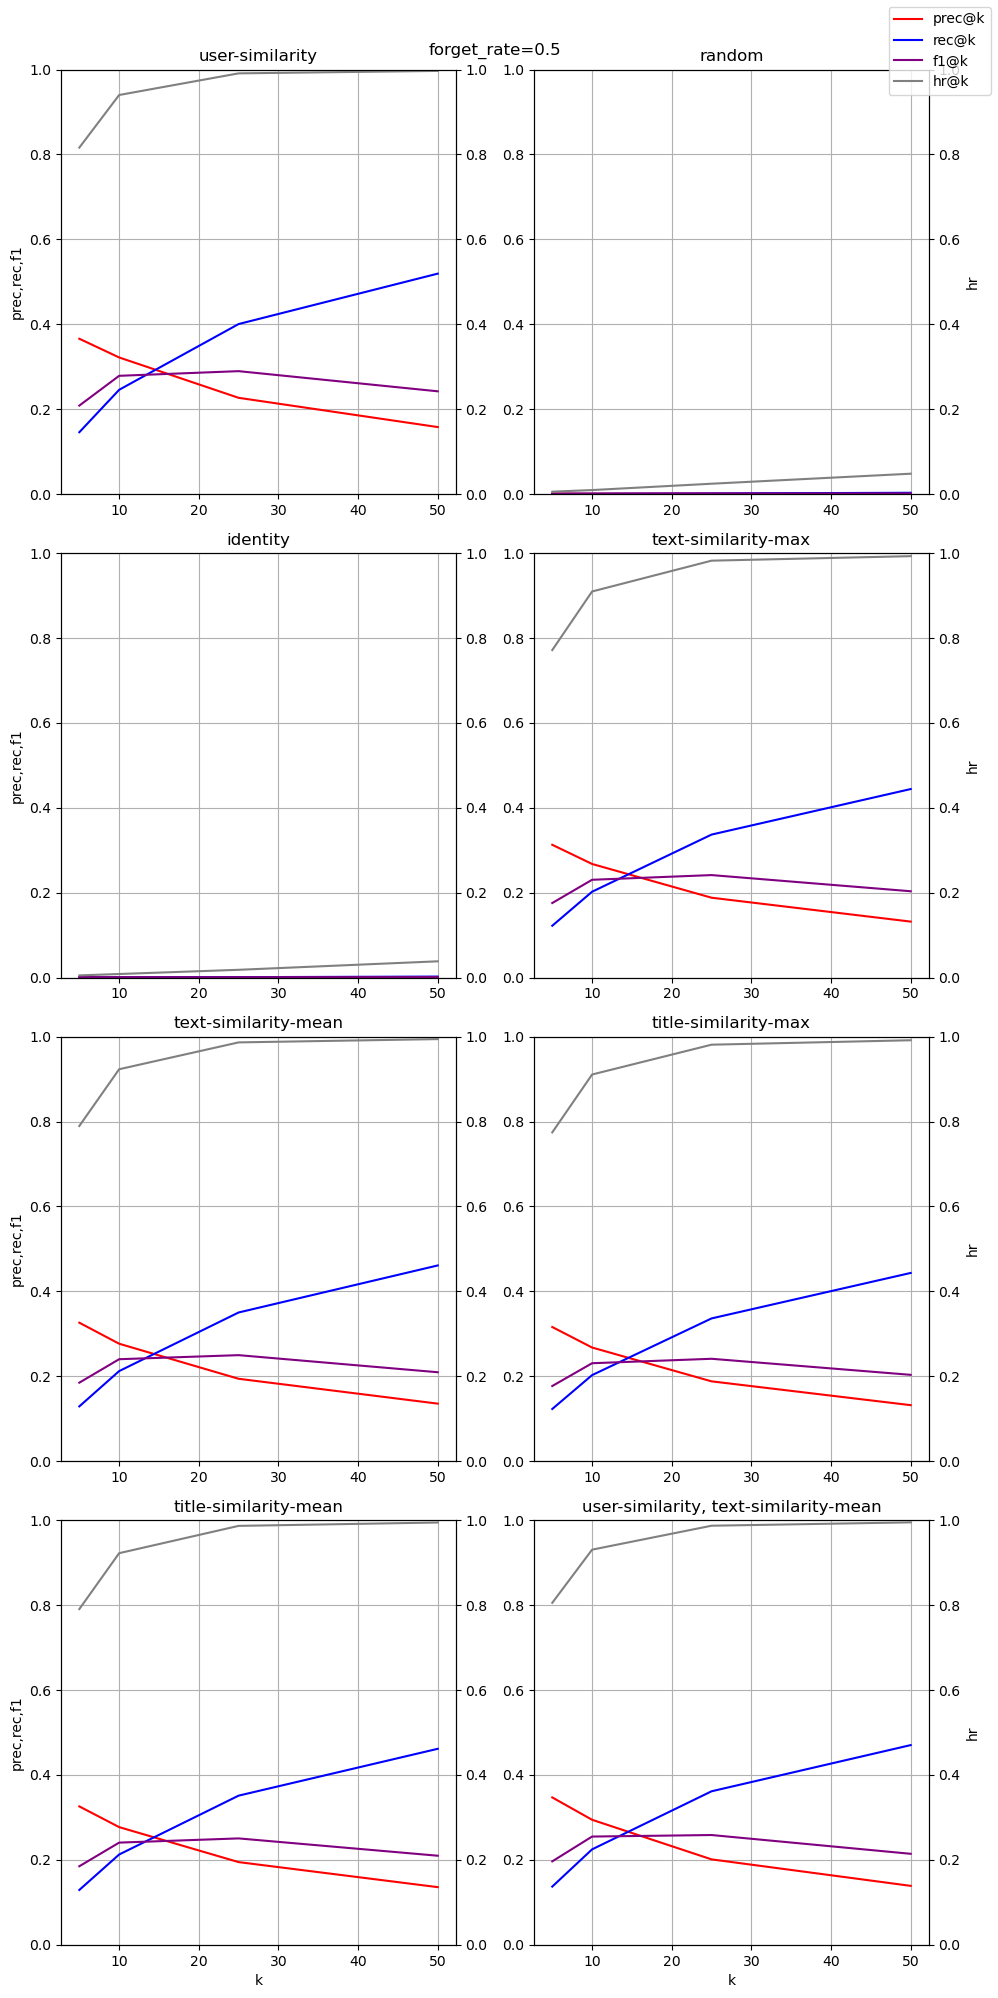

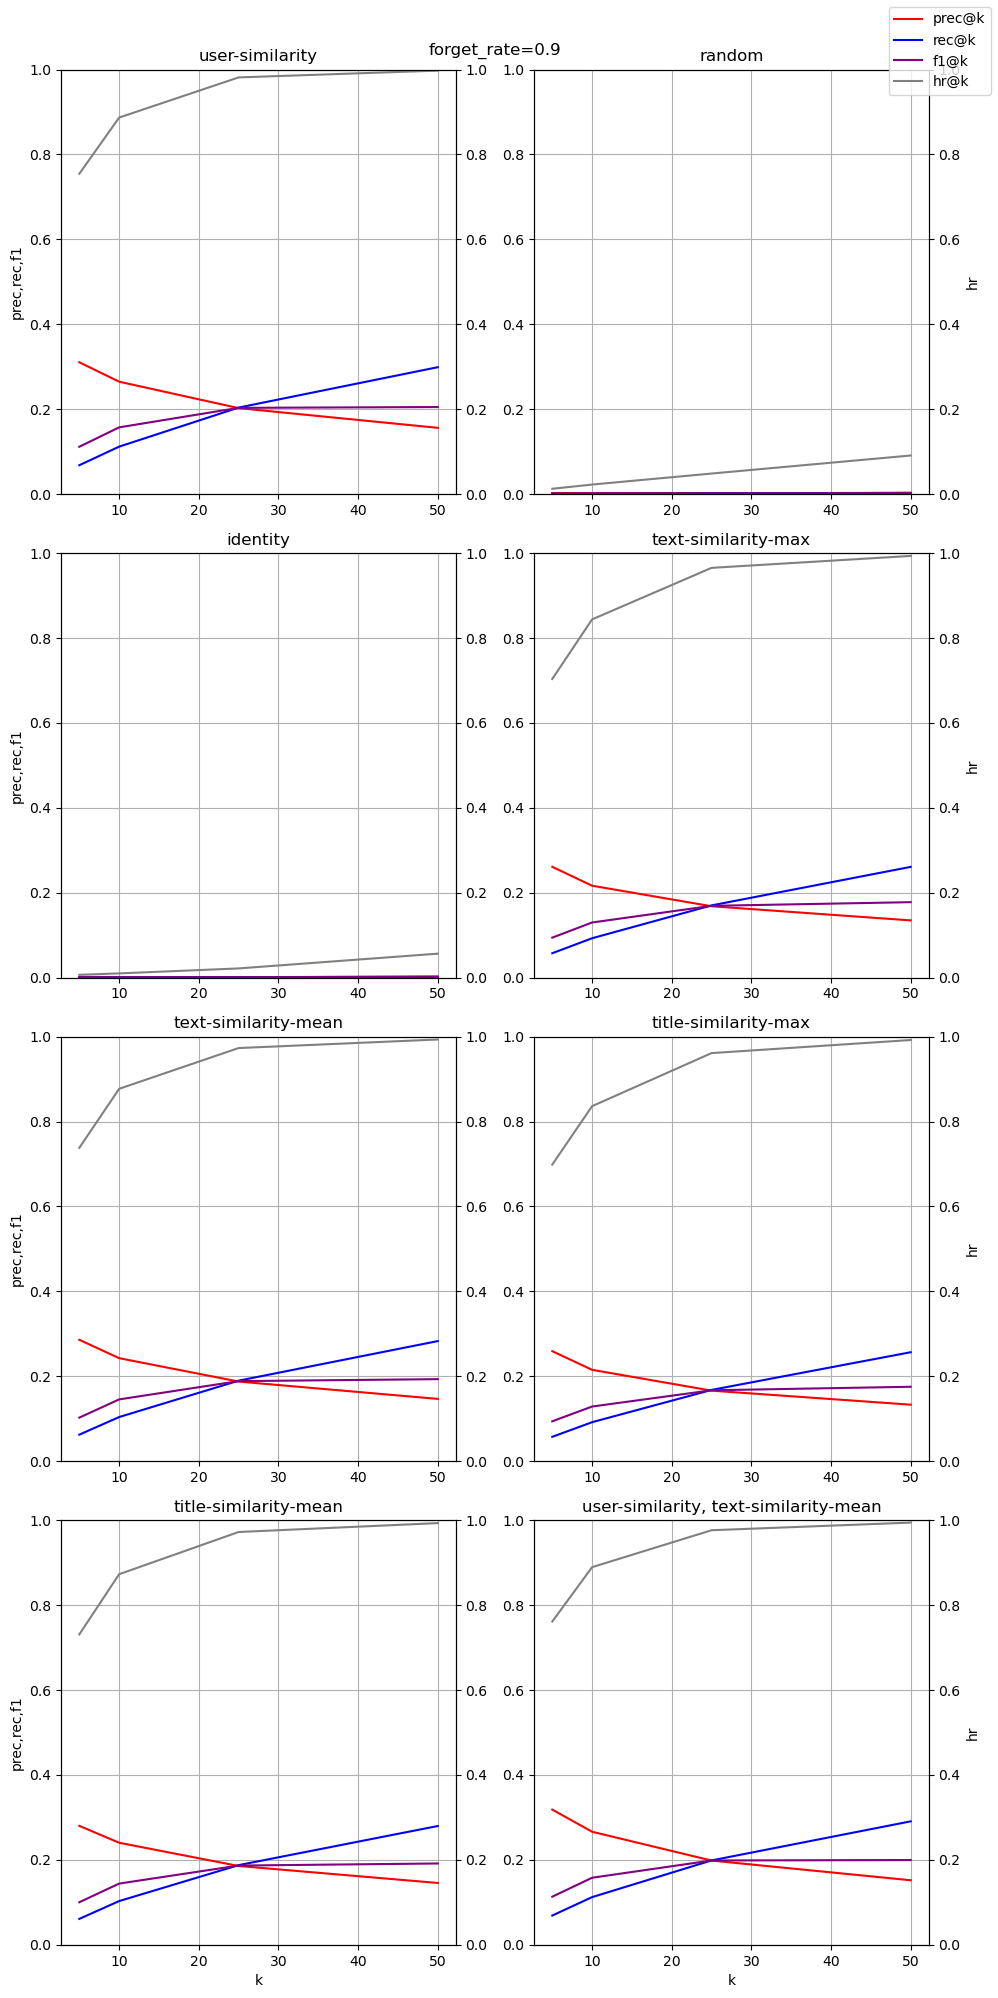

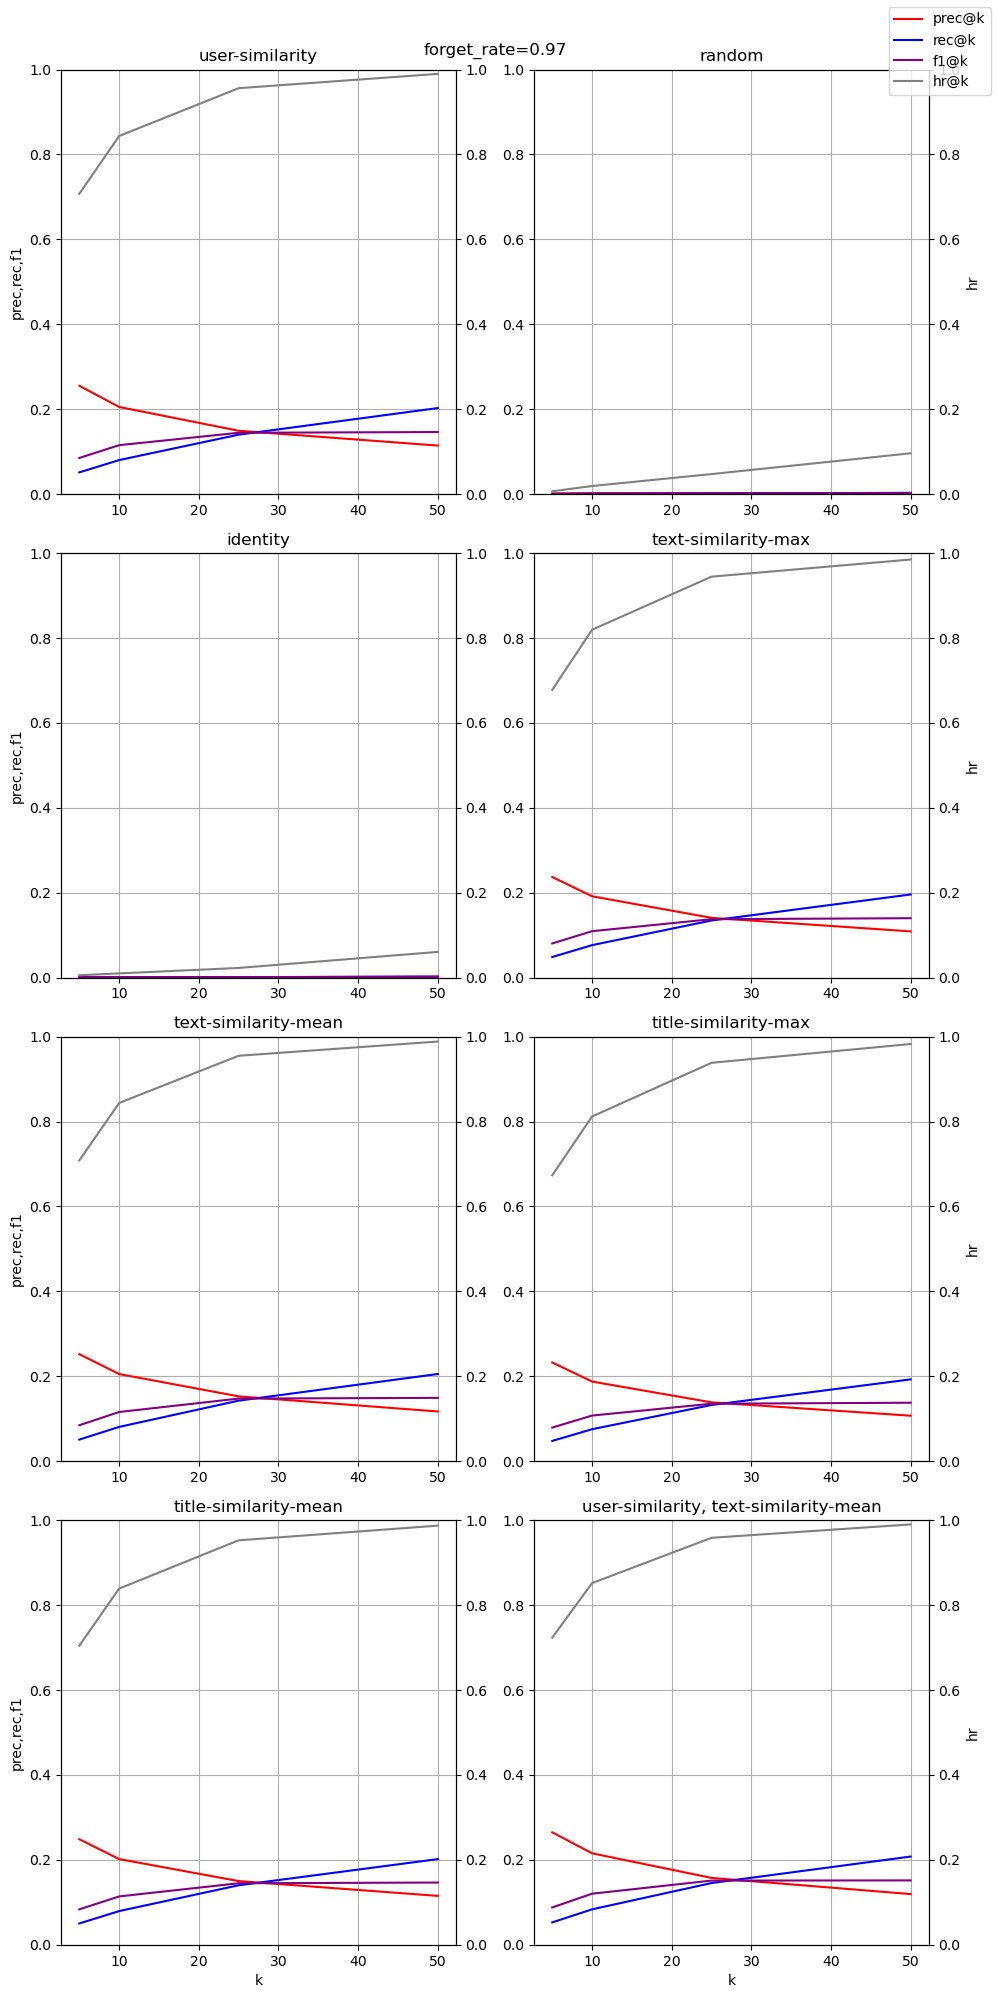

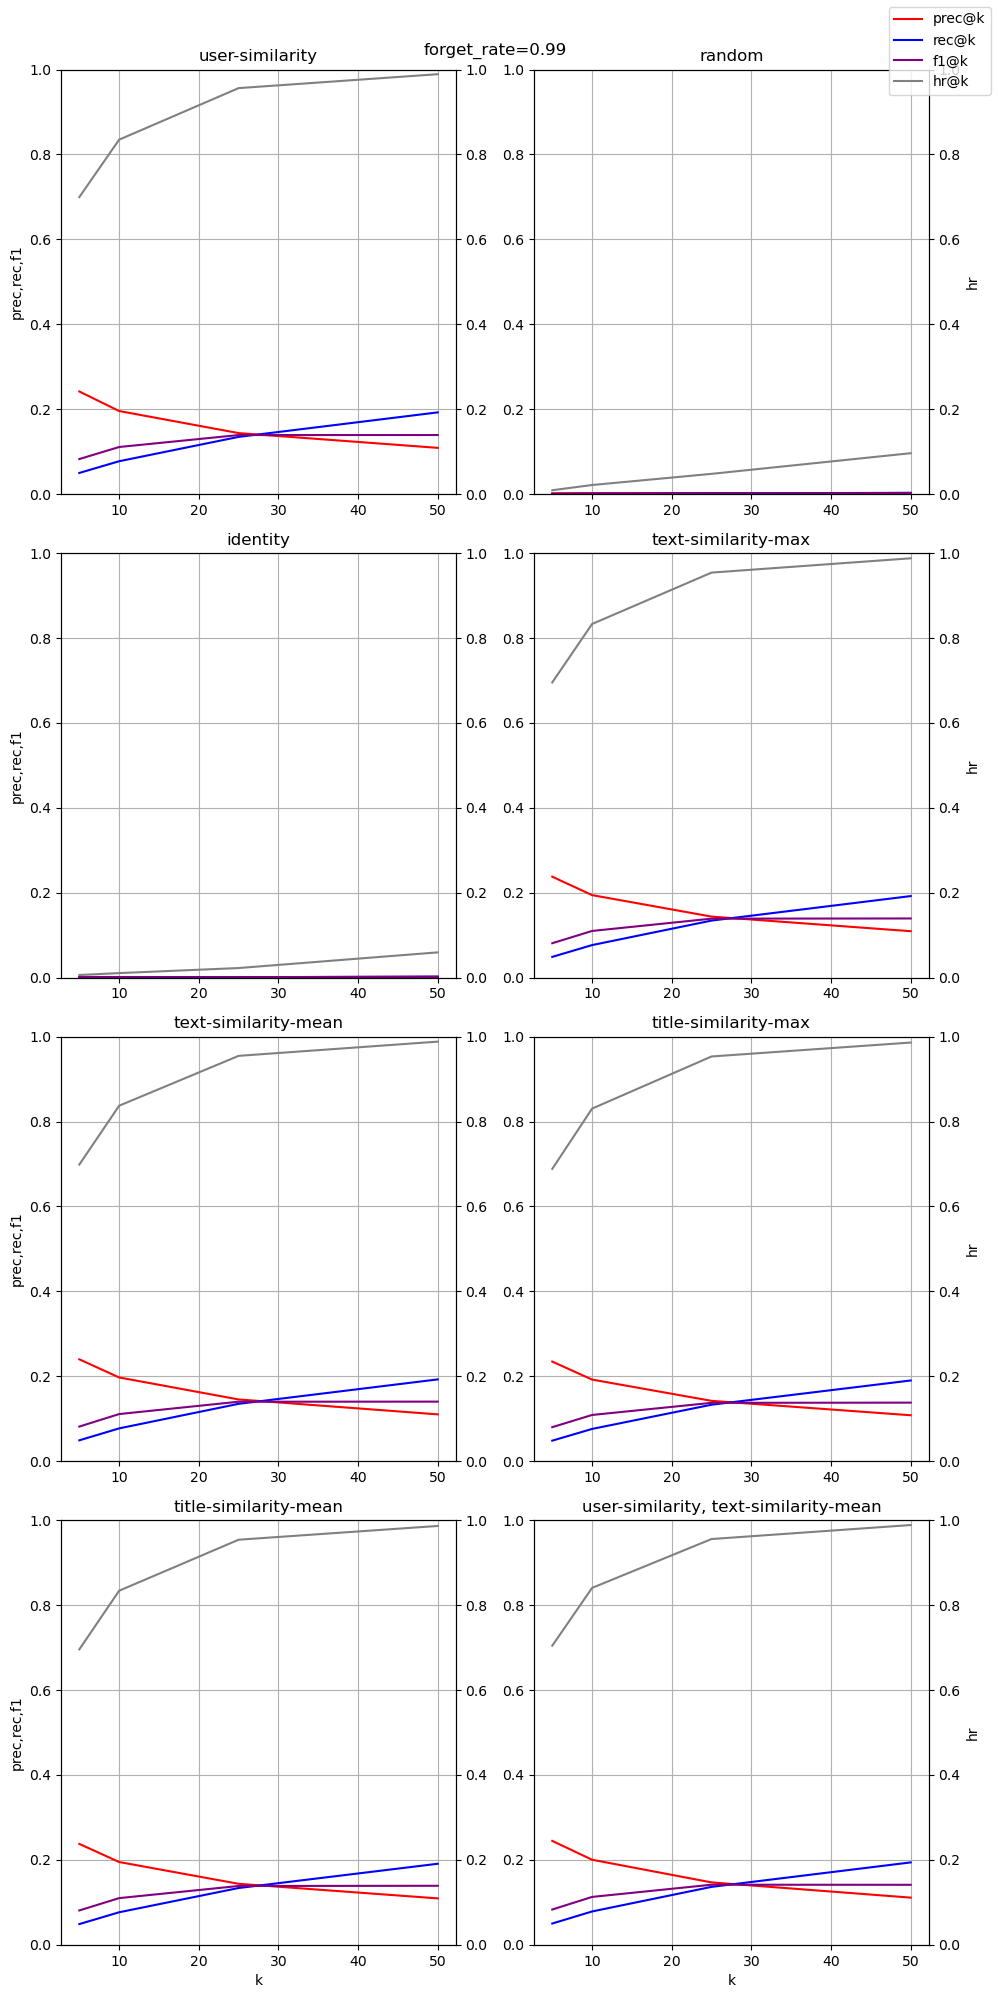

In [171]:
def get_field(df, field):
	return df[field].to_numpy()


def plot_results(forget_rate, weight_methods, series):
	nrows = len(weight_methods) // 2
	ncols = len(weight_methods) // nrows

	fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 20))

	for i, weight_method in enumerate(weight_methods):
		weight_method = join_weight_method(weight_method)
		ws = series[series["weight_method"] == weight_method]

		k = get_field(ws, "k")
		precision = get_field(ws, "precision")
		recall = get_field(ws, "recall")
		hr = get_field(ws, "hitrate")
		f1 = get_field(ws, "f1")

		row = i // ncols
		col = i % ncols

		wm_title = weight_method if type(weight_method) == str else ", ".join(weight_method)

		ax = axs[row, col]
		ax.title.set_text(wm_title)

		if row == nrows - 1:
			ax.set_xlabel("k")

		ax.set_ylim(0, 1)
		ax.grid()

		if i % ncols == 0:
			ax.set_ylabel("prec,rec,f1")

		if i == 0:
			ax.plot(k, precision, color="red", label="prec@k")
			ax.plot(k, recall, color="blue", label="rec@k")
			ax.plot(k, f1, color="purple", label="f1@k")
		else:
			ax.plot(k, precision, color="red")
			ax.plot(k, recall, color="blue")
			ax.plot(k, f1, color="purple")

		ax2 = ax.twinx()
		ax2.set_ylim(0, 1)

		if i % ncols == ncols - 1:
			ax2.set_ylabel("hr")

		if i == 0:
			ax2.plot(k, hr, color="grey", label="hr@k")
		else:
			ax2.plot(k, hr, color="grey")

	fig.suptitle(f"forget_rate={forget_rate}")
	fig.legend()
	fig.tight_layout()

	plt.show()


for forget_rate in forget_rates:
	weight_method = join_weight_method(weight_method)
	series = df[(df["forget_rate"] == forget_rate)].sort_values(by=["weight_method", "k"])
	plot_results(forget_rate, weight_methods, series)


# Using data and splits from Decrema et al. 2019


In [18]:
from split_loader import Loader as Loader2


loader2 = Loader2(
    "../RecSys2019_DeepLearning_Evaluation/data/data_split/splitted_data_URM_dict",
    "../RecSys2019_DeepLearning_Evaluation/data/data_split/splitted_data_ICM_dict",
)


In [19]:
urm_train = loader2.load_user_rating_matrix("train").toarray()
urm_validation = loader2.load_user_rating_matrix("validation").toarray()
urm_test = loader2.load_user_rating_matrix("test").toarray()


In [20]:
urm_train.shape, urm_validation.shape, urm_test.shape


((5551, 16980), (5551, 16980), (5551, 16980))

In [21]:
np.sum(urm_train), np.sum(urm_validation), np.sum(urm_test)


(5551.0, 1162.0, 199435.0)

In [22]:
num_ratings = np.sum(urm_train) + np.sum(urm_validation) + np.sum(urm_test)


def percentage(urm):
    percentage = 100 * np.sum(urm) / num_ratings
    return f"{percentage:.2f}%"


percentage(urm_train), percentage(urm_validation), percentage(urm_test)


('2.69%', '0.56%', '96.74%')

In [23]:
# Set non-zero shrinkage to avoid division by zero
urm_test_user_similarities = cosine_similarity_matrix(urm_train, urm_train, h=0.1)
urm_test_item_similarities = cosine_similarity_matrix(urm_train.T, urm_train.T, h=0.1)

urm_test_user_similarities.shape, urm_test_item_similarities.shape


((5551, 5551), (16980, 16980))

In [24]:
user_diff = np.sum(urm_test_user_similarities) - urm_test_user_similarities.shape[0] * urm_test_user_similarities.shape[1]
item_diff = np.sum(urm_test_item_similarities) - urm_test_item_similarities.shape[0] * urm_test_item_similarities.shape[1]

user_diff, item_diff


(-30805312.818181816, -288316423.45311403)